# Debugging inference 

Using latest version of coffea

In [66]:
from collections import defaultdict
import pickle as pkl
import pyarrow as pa
import awkward as ak
import numpy as np
import pandas as pd
import json
import os
import shutil
import pathlib
from typing import List, Optional, Dict
import pyarrow.parquet as pq

import importlib.resources

from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection

from coffea.nanoevents.methods.base import NanoEventsArray
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, PFNanoAODSchema
from coffea.nanoevents.methods import candidate, vector
import matplotlib.pyplot as plt
import numpy as np
import json

import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="Missing cross-reference index ")
np.seterr(invalid='ignore')

import hist as hist2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
from hist.intervals import clopper_pearson_interval

## NanoAODschema

We want to use PFNanoAODSchema since that load PFCands as a candidate particles, i.e. they have 4-vector properties.

https://coffeateam.github.io/coffea/api/coffea.nanoevents.PFNanoAODSchema.html
https://github.com/CoffeaTeam/coffea/blob/7dd4f863837a6319579f078c9e445c61d9106943/coffea/nanoevents/schemas/nanoaod.py#L282

Additionally, PFNanoAODSchema loads SecondaryVertices as SecondaryVertex:
https://github.com/CoffeaTeam/coffea/blob/7dd4f863837a6319579f078c9e445c61d9106943/coffea/nanoevents/schemas/nanoaod.py#L68
https://github.com/CoffeaTeam/coffea/blob/f2a99631dcf95b46bd0225b242b3ba512a30a89a/coffea/nanoevents/methods/nanoaod.py#L388

We do not neccessarily want this since this means we don't have a candidate 4-vector for the SecondaryVertex and we can't do operations like `delta_phi`. 
We need to modify this to a `mixin` of PFCand.

In [2]:
print(PFNanoAODSchema.mixins['PFCands'])
print(PFNanoAODSchema.mixins['SV'])

# interpret SV with PFCand behavior
PFNanoAODSchema.mixins["SV"] = "PFCand"

print(PFNanoAODSchema.mixins['SV'])

PFCand
SecondaryVertex
PFCand


## Opening file w PFNanoAODSchema

Here we manually open the file (only 200 entries), and we use `PFNanoAODSchema`.
We also open the json file that specifies how many pf candidates/svs are going to be used in the tagger, as well as any normalization that should be applied

In [3]:
file = 'dy_sample.root'
events = NanoEventsFactory.from_root(file, schemaclass=PFNanoAODSchema, entry_stop=200).events()

with open(f"03_31_ak8.json") as f:
    tagger_vars = json.load(f)

We define the selection such that it mimics the boostedHiggs selection. We use the fatjet closest to the lepton and obtain its index.

In [4]:
def build_p4(cand):
    return ak.zip(
        {
            "pt": cand.pt,
            "eta": cand.eta,
            "phi": cand.phi,
            "mass": cand.mass,
            "charge": cand.charge,
        },
        with_name="PtEtaPhiMCandidate",
        behavior=candidate.behavior,
    )

good_muons = (
    (events.Muon.pt > 30)
    & (np.abs(events.Muon.eta) < 2.4)
    & (np.abs(events.Muon.dz) < 0.1)
    & (np.abs(events.Muon.dxy) < 0.05)
    & (events.Muon.sip3d <= 4.0)
    & events.Muon.mediumId
)   
good_electrons = (
    (events.Electron.pt > 38)
    & (np.abs(events.Electron.eta) < 2.4)
    & ((np.abs(events.Electron.eta) < 1.44) | (np.abs(events.Electron.eta) > 1.57))
    & (np.abs(events.Electron.dz) < 0.1)
    & (np.abs(events.Electron.dxy) < 0.05)
    & (events.Electron.sip3d <= 4.0)
    & (events.Electron.mvaFall17V2noIso_WP90)
)

# get candidate lepton
goodleptons = ak.concatenate([events.Muon[good_muons], events.Electron[good_electrons]], axis=1)    # concat muons and electrons
goodleptons = goodleptons[ak.argsort(goodleptons.pt, ascending=False)]      # sort by pt
candidatelep = ak.firsts(goodleptons)   # pick highest pt
candidatelep_p4 = build_p4(candidatelep) 

# get candidate fj
fatjets = events.FatJet
good_fatjets = (
    (fatjets.pt > 200)
    & (abs(fatjets.eta) < 2.5)
    & fatjets.isTight
)
n_fatjets = ak.sum(good_fatjets, axis=1)
good_fatjets = fatjets[good_fatjets]        # select good fatjets
good_fatjets = good_fatjets[ak.argsort(good_fatjets.pt, ascending=False)]    # sort by pt
lep_in_fj_overlap_bool = ~ak.is_none(ak.firsts(good_fatjets.delta_r(candidatelep_p4) > 0.1))
good_fatjets = ak.mask(good_fatjets, lep_in_fj_overlap_bool)

# get idx and fj
fj_idx_lep = ak.argmin(good_fatjets.delta_r(candidatelep_p4), axis=1, keepdims=True)
candidatefj_lep = ak.firsts(good_fatjets[fj_idx_lep])

In [5]:
print(f'the candidate jet is jet # {fj_idx_lep[74]}')
print(f'the candidate jet is jet # {fj_idx_lep[92]}')

the candidate jet is jet # [0]
the candidate jet is jet # [1]


In [6]:
fatjet_label = "FatJet"
pfcands_label = "FatJetPFCands"
svs_label = "FatJetSVs"

# get the jet given the index (take firsts to avoid singletons)
jet = ak.firsts(events[fatjet_label][fj_idx_lep])

# print indices of events where we actually have a jet
print('Indices where jet pt > 0')
print(np.where((ak.fill_none(jet.pt,-1)>0).to_numpy()))    # fill "None" events by -1, contsruct a bool and get the inidices

Indices where jet pt > 0
(array([ 17,  48,  66,  74,  80,  81,  82,  90,  92, 104, 105, 116, 123,
       159, 160, 164]),)


## Now get feature functions

In [7]:
def get_pfcands_features(
    tagger_vars: dict,
    preselected_events: NanoEventsArray,
    fj_idx_lep,
    fatjet_label: str = "FatJetAK15",
    pfcands_label: str = "FatJetPFCands",
    normalize: bool = True,
) -> Dict[str, np.ndarray]:
    """
    Extracts the pf_candidate features specified in the ``tagger_vars`` dict from the
    ``preselected_events`` and returns them as a dict of numpy arrays
    """

    feature_dict = {}

    jet = ak.firsts(preselected_events[fatjet_label][fj_idx_lep])

    msk = preselected_events[pfcands_label].jetIdx == ak.firsts(fj_idx_lep)
    jet_ak_pfcands = preselected_events[pfcands_label][msk]
    jet_pfcands = (preselected_events.PFCands[jet_ak_pfcands.pFCandsIdx])

    # negative eta jets have -1 sign, positive eta jets have +1
    eta_sign = ak.values_astype(jet_pfcands.eta > 0, int) * 2 - 1
    feature_dict["pfcand_etarel"] = eta_sign * (jet_pfcands.eta - jet.eta)
    feature_dict["pfcand_phirel"] = jet.delta_phi(jet_pfcands)
    feature_dict["pfcand_abseta"] = np.abs(jet_pfcands.eta)

    feature_dict["pfcand_pt_log_nopuppi"] = np.log(jet_pfcands.pt)
    feature_dict["pfcand_e_log_nopuppi"] = np.log(jet_pfcands.energy)

    pdgIds = jet_pfcands.pdgId
    feature_dict["pfcand_isEl"] = np.abs(pdgIds) == 11
    feature_dict["pfcand_isMu"] = np.abs(pdgIds) == 13
    feature_dict["pfcand_isChargedHad"] = np.abs(pdgIds) == 211
    feature_dict["pfcand_isGamma"] = np.abs(pdgIds) == 22
    feature_dict["pfcand_isNeutralHad"] = np.abs(pdgIds) == 130

    feature_dict["pfcand_charge"] = jet_pfcands.charge
    feature_dict["pfcand_VTX_ass"] = jet_pfcands.pvAssocQuality
    feature_dict["pfcand_lostInnerHits"] = jet_pfcands.lostInnerHits
    feature_dict["pfcand_quality"] = jet_pfcands.trkQuality

    feature_dict["pfcand_normchi2"] = np.floor(jet_pfcands.trkChi2)

    feature_dict["pfcand_dz"] = jet_pfcands.dz
    feature_dict["pfcand_dxy"] = jet_pfcands.d0
    feature_dict["pfcand_dzsig"] = jet_pfcands.dz / jet_pfcands.dzErr
    feature_dict["pfcand_dxysig"] = jet_pfcands.d0 / jet_pfcands.d0Err

    # btag vars
    for var in tagger_vars["pf_features"]["var_names"]:
        if "btag" in var:
            feature_dict[var] = jet_ak_pfcands[var[len("pfcand_"):]]

    # pfcand mask
    feature_dict["pfcand_mask"] = (~(ak.pad_none(feature_dict["pfcand_abseta"], tagger_vars["pf_points"]["var_length"], axis=1, clip=True).to_numpy().mask)).astype(np.float32)

    # convert to numpy arrays and normalize features
    for var in tagger_vars["pf_features"]["var_names"]:
        a = (
            ak.pad_none(
                feature_dict[var], tagger_vars["pf_points"]["var_length"], axis=1, clip=True
            )
            .to_numpy()
            .filled(fill_value=0)
        ).astype(np.float32)

        if normalize:
            info = tagger_vars["pf_features"]["var_infos"][var]
            a = (a - info["median"]) * info["norm_factor"]
            a = np.clip(a, info.get("lower_bound", -5), info.get("upper_bound", 5))

        feature_dict[var] = a

    if normalize:
        var = "pfcand_normchi2"
        info = tagger_vars["pf_features"]["var_infos"][var]
        # finding what -1 transforms to
        chi2_min = -1 - info["median"] * info["norm_factor"]
        feature_dict[var][feature_dict[var] == chi2_min] = info["upper_bound"]
    return feature_dict

In [74]:
def get_svs_features(
    tagger_vars: dict,
    preselected_events: NanoEventsArray,
    fj_idx_lep,
    fatjet_label: str = "FatJetAK15",
    svs_label: str = "JetSVsAK15",
    normalize: bool = True,
) -> Dict[str, np.ndarray]:
    """
    Extracts the sv features specified in the ``tagger_vars`` dict from the
    ``preselected_events`` and returns them as a dict of numpy arrays
    """

    feature_dict = {}

    jet = ak.firsts(preselected_events[fatjet_label][fj_idx_lep])
    msk = preselected_events[svs_label].jetIdx == ak.firsts(fj_idx_lep)
    jet_svs = preselected_events.SV[
        preselected_events[svs_label].sVIdx[
            (preselected_events[svs_label].sVIdx != -1)
            * (msk)
        ]
    ]

    # negative eta jets have -1 sign, positive eta jets have +1
    eta_sign = ak.values_astype(jet_svs.eta > 0, int) * 2 - 1
    feature_dict["sv_etarel"] = eta_sign * (jet_svs.eta - jet.eta)
    feature_dict["sv_phirel"] = jet_svs.delta_phi(jet)
    feature_dict["sv_abseta"] = np.abs(jet_svs.eta)
    feature_dict["sv_mass"] = jet_svs.mass
    feature_dict["sv_pt_log"] = np.log(jet_svs.pt)

    feature_dict["sv_ntracks"] = jet_svs.ntracks
    feature_dict["sv_normchi2"] = jet_svs.chi2
    feature_dict["sv_dxy"] = jet_svs.dxy
    feature_dict["sv_dxysig"] = jet_svs.dxySig
    feature_dict["sv_d3d"] = jet_svs.dlen
    feature_dict["sv_d3dsig"] = jet_svs.dlenSig
    svpAngle = jet_svs.pAngle
    feature_dict["sv_costhetasvpv"] = -np.cos(svpAngle)

    feature_dict["sv_mask"] = (~(ak.pad_none(feature_dict["sv_etarel"], tagger_vars["sv_points"]["var_length"], axis=1, clip=True).to_numpy().mask)).astype(np.float32)

    # convert to numpy arrays and normalize features
    for var in tagger_vars["sv_features"]["var_names"]:
        a = (
            ak.pad_none(
                feature_dict[var], tagger_vars["sv_points"]["var_length"], axis=1, clip=True
            )
            .to_numpy()
            .filled(fill_value=0)
        ).astype(np.float32)

        if normalize:
            info = tagger_vars["sv_features"]["var_infos"][var]
            a = (a - info["median"]) * info["norm_factor"]
            a = np.clip(a, info.get("lower_bound", -5), info.get("upper_bound", 5))

        feature_dict[var] = a

    return feature_dict

In [85]:
fatjet_label = "FatJet"
pfcands_label = "FatJetPFCands"
svs_label = "FatJetSVs"

selection = candidatefj_lep.pt > 450

feature_dict = {
    **get_pfcands_features(tagger_vars, events[selection], fj_idx_lep[selection], fatjet_label, pfcands_label),
    **get_svs_features(tagger_vars, events[selection], fj_idx_lep[selection], fatjet_label, svs_label)
}

In [86]:
feature_dict.keys()

dict_keys(['pfcand_etarel', 'pfcand_phirel', 'pfcand_abseta', 'pfcand_pt_log_nopuppi', 'pfcand_e_log_nopuppi', 'pfcand_isEl', 'pfcand_isMu', 'pfcand_isChargedHad', 'pfcand_isGamma', 'pfcand_isNeutralHad', 'pfcand_charge', 'pfcand_VTX_ass', 'pfcand_lostInnerHits', 'pfcand_quality', 'pfcand_normchi2', 'pfcand_dz', 'pfcand_dxy', 'pfcand_dzsig', 'pfcand_dxysig', 'pfcand_mask', 'sv_etarel', 'sv_phirel', 'sv_abseta', 'sv_mass', 'sv_pt_log', 'sv_ntracks', 'sv_normchi2', 'sv_dxy', 'sv_dxysig', 'sv_d3d', 'sv_d3dsig', 'sv_costhetasvpv', 'sv_mask'])

## Triton inference

In [87]:
from typing import Dict

import numpy as np
from scipy.special import softmax
import awkward as ak
from coffea.nanoevents.methods.base import NanoEventsArray

import json

# import onnxruntime as ort

import time

import tritonclient.grpc as triton_grpc
import tritonclient.http as triton_http

from tqdm import tqdm


# adapted from https://github.com/lgray/hgg-coffea/blob/triton-bdts/src/hgg_coffea/tools/chained_quantile.py
class wrapped_triton:
    def __init__(
        self,
        model_url: str,
        batch_size: int,
        torchscript: bool = True,
    ) -> None:
        fullprotocol, location = model_url.split("://")
        _, protocol = fullprotocol.split("+")
        address, model, version = location.split("/")

        self._protocol = protocol
        self._address = address
        self._model = model
        self._version = version

        self._batch_size = batch_size
        self._torchscript = torchscript

    def __call__(self, input_dict: Dict[str, np.ndarray]) -> np.ndarray:
        if self._protocol == "grpc":
            client = triton_grpc.InferenceServerClient(url=self._address, verbose=False)
            triton_protocol = triton_grpc
        elif self._protocol == "http":
            client = triton_http.InferenceServerClient(
                url=self._address,
                verbose=False,
                concurrency=12,
            )
            triton_protocol = triton_http
        else:
            raise ValueError(f"{self._protocol} does not encode a valid protocol (grpc or http)")

        # manually split into batches for gpu inference
        input_size = input_dict[list(input_dict.keys())[0]].shape[0]
        print(f"size of input = {input_size}")

        outs = [
            self._do_inference(
                {key: input_dict[key][batch: batch + self._batch_size] for key in input_dict},
                triton_protocol,
                client,
            )
            for batch in tqdm(
                range(0, input_dict[list(input_dict.keys())[0]].shape[0], self._batch_size)
            )
        ]

        return np.concatenate(outs) if input_size > 0 else outs

    def _do_inference(
        self, input_dict: Dict[str, np.ndarray], triton_protocol, client
    ) -> np.ndarray:
        # Infer
        inputs = []

        for key in input_dict:
            input = triton_protocol.InferInput(key, input_dict[key].shape, "FP32")
            input.set_data_from_numpy(input_dict[key])
            inputs.append(input)

        out_name = "softmax__0" if self._torchscript else "softmax"

        output = triton_protocol.InferRequestedOutput(out_name)

        request = client.infer(
            self._model,
            model_version=self._version,
            inputs=inputs,
            outputs=[output],
        )

        return request.as_numpy(out_name)


def runInferenceTriton(
    tagger_resources_path: str, events: NanoEventsArray, fj_idx_lep
) -> dict:
    total_start = time.time()

    with open(f"{tagger_resources_path}/triton_config.json") as f:
        triton_config = json.load(f)

    with open(f"{tagger_resources_path}/{triton_config['model_name']}.json") as f:
        tagger_vars = json.load(f)

    triton_model = wrapped_triton(
        triton_config["model_url"], triton_config["batch_size"], torchscript=True
    )

    fatjet_label = "FatJet"
    pfcands_label = "FatJetPFCands"
    svs_label = "FatJetSVs"
    jet_label = "ak8"

    # prepare inputs for both fat jets
    tagger_inputs = []

    feature_dict = {
        **get_pfcands_features(tagger_vars, events, fj_idx_lep, fatjet_label, pfcands_label),
        **get_svs_features(tagger_vars, events, fj_idx_lep, fatjet_label, svs_label),
    }

    for input_name in tagger_vars["input_names"]:
        for key in tagger_vars[input_name]["var_names"]:
            np.expand_dims(feature_dict[key], 1)

    tagger_inputs = {
        f"{input_name}__{i}": np.concatenate(
            [
                np.expand_dims(feature_dict[key], 1)
                for key in tagger_vars[input_name]["var_names"]
            ],
            axis=1,
        )
        for i, input_name in enumerate(tagger_vars["input_names"])
    }
    print(tagger_inputs['pf_points__0'].shape)
    # run inference for both fat jets
    tagger_outputs = []
    print(f"Running inference for candidate Jet")
    start = time.time()
    tagger_outputs = triton_model(tagger_inputs)
    time_taken = time.time() - start
    print(f"Inference took {time_taken:.1f}s")

    print('tagger_outputs shape', tagger_outputs.shape)
    pnet_vars_list = []
    if len(tagger_outputs):
        pnet_vars = {
            f"{jet_label}FatJetParticleNetHWWMD_probQCD": np.sum(tagger_outputs[:, :5], axis=1),
            f"{jet_label}FatJetParticleNetHWWMD_probHWW3q": tagger_outputs[:, -2],
            f"{jet_label}FatJetParticleNetHWWMD_probHWW4q": tagger_outputs[:, -1],
            f"{jet_label}FatJetParticleNetHWWMD_THWW4q": (tagger_outputs[:, -2] + tagger_outputs[:, -1]) / np.sum(tagger_outputs, axis=1),
        }
    else:
        pnet_vars = {
            f"{jet_label}FatJetParticleNetHWWMD_probQCD": np.array([]),
            f"{jet_label}FatJetParticleNetHWWMD_probHWW3q": np.array([]),
            f"{jet_label}FatJetParticleNetHWWMD_probHWW4q": np.array([]),
            f"{jet_label}FatJetParticleNetHWWMD_THWW4q": np.array([]),
        }
    
    print(f"Total time taken: {time.time() - total_start:.1f}s")
    return pnet_vars

In [88]:
tagger_resources_path = 'binder_tagger_resources'
pfnet_vars = runInferenceTriton(
    tagger_resources_path, events, fj_idx_lep
)

  0%|          | 0/1 [00:00<?, ?it/s]

(200, 2, 100)
Running inference for candidate Jet
size of input = 200


100%|██████████| 1/1 [00:04<00:00,  4.52s/it]

Inference took 4.5s
tagger_outputs shape (200, 6)
Total time taken: 4.7s


In [44]:
pfnet_vars.keys()

dict_keys(['ak8FatJetParticleNetHWWMD_probQCD', 'ak8FatJetParticleNetHWWMD_probHWW3q', 'ak8FatJetParticleNetHWWMD_probHWW4q', 'ak8FatJetParticleNetHWWMD_THWW4q'])

In [51]:
pfnet_vars['ak8FatJetParticleNetHWWMD_probQCD']

array([ 0.82810056,  0.82810056,  0.82810056,  0.82810056,  0.82810056,
        0.82810056,  0.82810056,  0.82810056,  0.82810056,  0.82810056,
        0.82810056,  0.82810056,  0.82810056,  0.82810056,  0.82810056,
        0.82810056,  0.82810056,  0.9994266 ,  0.82810056,  0.82810056,
        0.82810056,  0.82810056,  0.82810056,  0.82810056,  0.82810056,
        0.82810056,  0.82810056,  0.82810056,  0.82810056,  0.82810056,
        0.82810056,  0.82810056,  0.82810056,  0.82810056,  0.82810056,
        0.82810056,  0.82810056,  0.82810056,  0.82810056,  0.82810056,
        0.82810056,  0.82810056,  0.82810056,  0.82810056,  0.82810056,
        0.82810056,  0.82810056,  0.82810056,  0.99979746,  0.82810056,
        0.82810056,  0.82810056,  0.82810056,  0.82810056,  0.82810056,
        0.82810056,  0.82810056,  0.82810056,  0.82810056,  0.82810056,
        0.82810056,  0.82810056,  0.82810056,  0.82810056,  0.82810056,
        0.82810056,  0.7367499 ,  0.82810056,  0.82810056,  0.82

## Debugging

In [157]:
import os
import numpy as np
import awkward as ak
import gzip
import pickle
import importlib.resources
import correctionlib

with importlib.resources.path("binder_data", "ULvjets_corrections.json") as filename:
    vjets_kfactors = correctionlib.CorrectionSet.from_file(str(filename))

def add_VJets_kFactors(weights, genpart, dataset):
    """Revised version of add_VJets_NLOkFactor, for both NLO EW and ~NNLO QCD"""
    def get_vpt(check_offshell=False):
        """Only the leptonic samples have no resonance in the decay tree, and only
        when M is beyond the configured Breit-Wigner cutoff (usually 15*width)
        """
        boson = ak.firsts(genpart[
            ((genpart.pdgId == 23)|(abs(genpart.pdgId) == 24))
            & genpart.hasFlags(["fromHardProcess", "isLastCopy"])
        ])
        if check_offshell:
            offshell = genpart[
                genpart.hasFlags(["fromHardProcess", "isLastCopy"])
                & ak.is_none(boson)
                & (abs(genpart.pdgId) >= 11) & (abs(genpart.pdgId) <= 16)
            ].sum()
            return ak.where(ak.is_none(boson.pt), offshell.pt, boson.pt)
        return np.array(ak.fill_none(boson.pt, 0.))

    common_systs = [
        "d1K_NLO",
        "d2K_NLO",
        "d3K_NLO",
        "d1kappa_EW",
    ]
    zsysts = common_systs + [
        "Z_d2kappa_EW",
        "Z_d3kappa_EW",
    ]
    wsysts = common_systs + [
        "W_d2kappa_EW",
        "W_d3kappa_EW",
    ]

    if "ZJetsToQQ_HT" in dataset or "DYJetsToLL" in dataset:
        vpt = get_vpt()
        qcdcorr = vjets_kfactors["ULZ_MLMtoFXFX"].evaluate(vpt)
        ewkcorr = vjets_kfactors["Z_FixedOrderComponent"]
    elif "WJetsToQQ_HT" in dataset or "WJetsToLNu" in dataset:
        vpt = get_vpt()
        qcdcorr = vjets_kfactors["ULW_MLMtoFXFX"].evaluate(vpt)
        ewkcorr = vjets_kfactors["W_FixedOrderComponent"]

with importlib.resources.path("binder_data", "fatjet_triggerSF_Hbb.json") as filename:
    jet_triggerSF = correctionlib.CorrectionSet.from_file(str(filename))

def add_jetTriggerSF(weights, leadingjet, year, selection):
    def mask(w):
        return np.where(selection.all('oneFatjet'), w, 1.)
    jet_pt = np.array(ak.fill_none(leadingjet.pt, 0.))
    jet_msd = np.array(ak.fill_none(leadingjet.msoftdrop, 0.))  # note: uncorrected
    nom = mask(jet_triggerSF[f'fatjet_triggerSF{year}'].evaluate("nominal", jet_pt, jet_msd))
    up = mask(jet_triggerSF[f'fatjet_triggerSF{year}'].evaluate("stat_up", jet_pt, jet_msd))
    down = mask(jet_triggerSF[f'fatjet_triggerSF{year}'].evaluate("stat_dn", jet_pt, jet_msd))
    weights.add('trigger_had', nom, up, down)

def add_pdf_weight(weights, pdf_weights):
    nweights = len(weights.weight())
    nom = np.ones(nweights)
    up = np.ones(nweights)
    down = np.ones(nweights)
    docstring = pdf_weights.__doc__

    # NNPDF31_nnlo_hessian_pdfas
    # https://lhapdfsets.web.cern.ch/current/NNPDF31_nnlo_hessian_pdfas/NNPDF31_nnlo_hessian_pdfas.info
    if True:
        # Hessian PDF weights
        # Eq. 21 of https://arxiv.org/pdf/1510.03865v1.pdf
        arg = pdf_weights[:, 1:-2] - np.ones((nweights, 100))
        summed = ak.sum(np.square(arg), axis=1)
        pdf_unc = np.sqrt((1. / 99.) * summed)
        weights.add('PDF_weight', nom, pdf_unc + nom)

        # alpha_S weights
        # Eq. 27 of same ref
        as_unc = 0.5 * (pdf_weights[:, 102] - pdf_weights[:, 101])
        weights.add('aS_weight', nom, as_unc + nom)

        # PDF + alpha_S weights
        # Eq. 28 of same ref
        pdfas_unc = np.sqrt(np.square(pdf_unc) + np.square(as_unc))
        weights.add('PDFaS_weight', nom, pdfas_unc + nom)

    else:
        weights.add('aS_weight', nom, up, down)
        weights.add('PDF_weight', nom, up, down)
        weights.add('PDFaS_weight', nom, up, down)

# 7-point scale variations
def add_scalevar_7pt(weights,var_weights):
    docstring = var_weights.__doc__
    nweights = len(weights.weight())

    nom   = np.ones(nweights)
    up    = np.ones(nweights)
    down  = np.ones(nweights)
 
    if len(var_weights) > 0:
        if len(var_weights[0]) == 9: 
            up = np.maximum.reduce([var_weights[:,0],var_weights[:,1],var_weights[:,3],var_weights[:,5],var_weights[:,7],var_weights[:,8]])
            down = np.minimum.reduce([var_weights[:,0],var_weights[:,1],var_weights[:,3],var_weights[:,5],var_weights[:,7],var_weights[:,8]])
        elif len(var_weights[0]) > 1:
            print("Scale variation vector has length ", len(var_weights[0]))
    weights.add('scalevar_7pt', nom, up, down)

# 3-point scale variations
def add_scalevar_3pt(weights,var_weights):
    docstring = var_weights.__doc__
    
    nweights = len(weights.weight())

    nom   = np.ones(nweights)
    up    = np.ones(nweights)
    down  = np.ones(nweights)

    if len(var_weights) > 0:
        if len(var_weights[0]) == 9:
            up = np.maximum(var_weights[:,0], var_weights[:,8])
            down = np.minimum(var_weights[:,0], var_weights[:,8])
        elif len(var_weights[0]) > 1:
            print("Scale variation vector has length ", len(var_weights[0]))

    weights.add('scalevar_3pt', nom, up, down)

def add_ps_weight(weights, ps_weights):
    nweights = len(weights.weight())
    nom = np.ones(nweights)
    up_isr = np.ones(nweights)
    down_isr = np.ones(nweights)
    up_fsr = np.ones(nweights)
    down_fsr = np.ones(nweights)

    if ps_weights is not None:
        if len(ps_weights[0]) == 4:
            up_isr = ps_weights[:, 0]
            down_isr = ps_weights[:, 2]
            up_fsr = ps_weights[:, 1]
            down_fsr = ps_weights[:, 3]
        else:
            warnings.warn(f"PS weight vector has length {len(ps_weights[0])}")
    weights.add('UEPS_ISR', nom, up_isr, down_isr)
    weights.add('UEPS_FSR', nom, up_fsr, down_fsr)

def build_lumimask(filename):
    from coffea.lumi_tools import LumiMask
    with importlib.resources.path("binder_data", filename) as path:
        return LumiMask(path)
lumi_masks = {
    "2016": build_lumimask("Cert_271036-284044_13TeV_Legacy2016_Collisions16_JSON.txt"),
    "2017": build_lumimask("Cert_294927-306462_13TeV_UL2017_Collisions17_GoldenJSON.txt"),
    "2018": build_lumimask("Cert_314472-325175_13TeV_Legacy2018_Collisions18_JSON.txt"),
}


"""
CorrectionLib files are available from: /cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration - synced daily
"""
pog_correction_path = "/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/"
pog_jsons = {
    "muon": ["MUO", "muon_Z.json.gz"],
    "electron": ["EGM", "electron.json.gz"],
    "pileup": ["LUM", "puWeights.json.gz"],
}


def get_UL_year(year):
    if year == "2016":
        year = "2016postVFP"
    elif year == "2016APV":
        year = "2016preVFP"
    return f"{year}_UL"


def get_pog_json(obj, year):
    try:
        pog_json = pog_jsons[obj]
    except:
        print(f'No json for {obj}')
    year = get_UL_year(year)
    return f"{pog_correction_path}POG/{pog_json[0]}/{year}/{pog_json[1]}"
    # os.system(f"cp {pog_correction_path}POG/{pog_json[0]}/{year}/{pog_json[1]} boostedhiggs/data/POG_{pog_json[0]}_{year}_{pog_json[1]}")
    # fname = ""
    # with importlib.resources.path("boostedhiggs.data", f"POG_{pog_json[0]}_{year}_{pog_json[1]}") as filename:
    #     fname = str(filename)
    # print(fname)
    # return fname

"""
Lepton Scale Factors
----

Muons:
https://twiki.cern.ch/twiki/bin/view/CMS/MuonUL2016
https://twiki.cern.ch/twiki/bin/view/CMS/MuonUL2017
https://twiki.cern.ch/twiki/bin/view/CMS/MuonUL2018

- UL CorrectionLib html files:
  https://cms-nanoaod-integration.web.cern.ch/commonJSONSFs/MUO_muon_Z_Run2_UL/
  e.g. one example of the correction json files can be found here:
  https://gitlab.cern.ch/cms-muonPOG/muonefficiencies/-/raw/master/Run2/UL/2017/2017_trigger/Efficiencies_muon_generalTracks_Z_Run2017_UL_SingleMuonTriggers_schemaV2.json
  - Trigger iso and non-iso
  - Isolation: We use RelIso<0.25 (LooseRelIso) with medium prompt ID
  - Reconstruction ID: We use medium prompt ID

Electrons:
- UL CorrectionLib htmlfiles:
  https://cms-nanoaod-integration.web.cern.ch/commonJSONSFs/EGM_electron_Run2_UL/
  - ID: wp90noiso
  - Reconstruction: RecoAbove20
  - Trigger:
    Looks like the EGM group does not provide them but applying these for now.
    https://twiki.cern.ch/twiki/bin/viewauth/CMS/EgHLTScaleFactorMeasurements (derived by Siqi Yuan)
    These include 2017: (HLT_ELE35 OR HLT_ELE115 OR HLT_Photon200)
    and 2018: (HLT_Ele32 OR HLT_ELE115 OR HLT_Photon200)
  - Isolation:
    No SFs for RelIso?
"""

lepton_corrections = {
    "trigger_iso": {
        "muon": {  # For IsoMu24 (| IsoTkMu24 )
            "2016APV": "NUM_IsoMu24_or_IsoTkMu24_DEN_CutBasedIdTight_and_PFIsoTight",  # preVBP
            "2016": "NUM_IsoMu24_or_IsoTkMu24_DEN_CutBasedIdTight_and_PFIsoTight",  # postVBF
            "2017": "NUM_IsoMu27_DEN_CutBasedIdTight_and_PFIsoTight",
            "2018": "NUM_IsoMu24_DEN_CutBasedIdTight_and_PFIsoTight",
        },
    },
    "trigger_noniso": {
        "muon": {  # For Mu50 (| TkMu50 )
            "2016APV": "NUM_Mu50_or_TkMu50_DEN_CutBasedIdGlobalHighPt_and_TkIsoLoose",
            "2016": "NUM_Mu50_or_TkMu50_DEN_CutBasedIdGlobalHighPt_and_TkIsoLoose",
            "2017": "NUM_Mu50_or_OldMu100_or_TkMu100_DEN_CutBasedIdGlobalHighPt_and_TkIsoLoose",
            "2018": "NUM_Mu50_or_OldMu100_or_TkMu100_DEN_CutBasedIdGlobalHighPt_and_TkIsoLoose",
        },
    },
    "isolation": {
        "muon": {
            "2016APV": "NUM_LooseRelIso_DEN_MediumPromptID",
            "2016": "NUM_LooseRelIso_DEN_MediumPromptID",
            "2017": "NUM_LooseRelIso_DEN_MediumPromptID",
            "2018": "NUM_LooseRelIso_DEN_MediumPromptID",
        },
        # "electron": {
        # },
    },
    # NOTE: We do not have SFs for mini-isolation yet
    "id": {
        "muon": {
            "2016APV": "NUM_MediumPromptID_DEN_TrackerMuons",
            "2016": "NUM_MediumPromptID_DEN_TrackerMuons",
            "2017": "NUM_MediumPromptID_DEN_TrackerMuons",
            "2018": "NUM_MediumPromptID_DEN_TrackerMuons",
        },
        # NOTE: should check that we do not have electrons w pT>500 GeV (I do not think we do)
        "electron": {
            "2016APV": "wp90noiso",
            "2016": "wp90noiso",
            "2017": "wp90noiso",
            "2018": "wp90noiso",
        },
    },
    "reco": {
        "electron": {
            "2016APV": "RecoAbove20",
            "2016": "RecoAbove20",
            "2017": "RecoAbove20",
            "2018": "RecoAbove20",
        },
    },
}


def add_lepton_weight(weights, lepton, year, lepton_type="muon"):
    ul_year = get_UL_year(year)
    if lepton_type == "electron":
        ul_year = ul_year.replace('_UL', '')
    cset = correctionlib.CorrectionSet.from_file(get_pog_json(lepton_type, year))

    def set_isothreshold(corr, value, lepton_pt, lepton_type):
        iso_threshold = {
            "muon": 55.,
            "electron": 120.,
        }[lepton_type]
        if corr == "trigger_iso":
            value[lepton_pt > iso_threshold] = 1.
        elif corr == "trigger_noniso":
            value[lepton_pt < iso_threshold] = 1.
        elif corr == "isolation":
            value[lepton_pt > iso_threshold] = 1.
        return value

    def get_clip(lep_pt, lep_eta, lepton_type,corr=None):
        clip_pt = [0., 2000]
        clip_eta = [-2.4999, 2.4999]
        if lepton_type == "electron":
            clip_pt = [10.0, 499.999]
            if corr == "reco":
                clip_pt = [20.1, 499.999]
        elif lepton_type == "muon":
            clip_pt = [30., 1000.]
            clip_eta = [0., 2.3999]
            if corr == "trigger_noniso":
                clip_pt = [52., 1000.]
        lepton_pt = np.clip(lep_pt, clip_pt[0], clip_pt[1])
        lepton_eta = np.clip(lep_eta, clip_eta[0], clip_eta[1])
        return lepton_pt,lepton_eta

    lep_pt = np.array(ak.fill_none(lepton.pt, 0.))
    lep_eta = np.array(ak.fill_none(lepton.eta, 0.))
    if lepton_type=="muon": lep_eta = np.abs(lep_eta)

    for corr,corrDict in lepton_corrections.items():
        if lepton_type not in corrDict.keys():
            continue
        if year not in corrDict[lepton_type].keys():
            continue
        json_map_name = corrDict[lepton_type][year]

        lepton_pt,lepton_eta = get_clip(lep_pt, lep_eta, lepton_type, corr)

        values = {}
        if lepton_type == "muon":
            values["nominal"] = cset[json_map_name].evaluate(ul_year, lepton_eta, lepton_pt, "sf")
        else:
            values["nominal"] = cset["UL-Electron-ID-SF"].evaluate(ul_year, "sf", json_map_name, lepton_eta, lepton_pt)

        if lepton_type == "muon":
            values["up"] = cset[json_map_name].evaluate(ul_year, lepton_eta, lepton_pt, "systup")
            values["down"] = cset[json_map_name].evaluate(ul_year, lepton_eta, lepton_pt, "systdown")
        else:
            values["up"] = cset["UL-Electron-ID-SF"].evaluate(ul_year, "sfup", json_map_name, lepton_eta, lepton_pt)
            values["down"] = cset["UL-Electron-ID-SF"].evaluate(ul_year, "sfdown", json_map_name, lepton_eta, lepton_pt)

        for key, val in values.items():
            # restrict values to 1 for some SFs if we are above/below the ISO threshold
            values[key] = set_isothreshold(corr, val, np.array(ak.fill_none(lepton.pt, 0.)), lepton_type)

        # add weights (for now only the nominal weight)
        weights.add(f"{corr}_{lepton_type}", values["nominal"], values["up"], values["down"])
        
    # quick hack to add electron trigger SFs
    if lepton_type=="electron":
        corr="trigger"
        with importlib.resources.path("binder_data", f"electron_trigger_{ul_year}_UL.json") as filename:
            cset = correctionlib.CorrectionSet.from_file(str(filename))
            lepton_pt,lepton_eta = get_clip(lep_pt, lep_eta, lepton_type, corr)
            # stil need to add uncertanties..
            values["nominal"] = cset["UL-Electron-Trigger-SF"].evaluate( lepton_eta, lepton_pt )   
            #print(values["nominal"][lep_pt>30])
            weights.add(f"{corr}_{lepton_type}", values["nominal"])


def add_pileup_weight(weights, year, mod, nPU):
    """
    Should be able to do something similar to lepton weight but w pileup
    e.g. see here: https://cms-nanoaod-integration.web.cern.ch/commonJSONSFs/LUMI_puWeights_Run2_UL/
    """
    cset = correctionlib.CorrectionSet.from_file(get_pog_json("pileup", year + mod))

    year_to_corr = {'2016': 'Collisions16_UltraLegacy_goldenJSON',
                    '2017': 'Collisions17_UltraLegacy_goldenJSON',
                    '2018': 'Collisions18_UltraLegacy_goldenJSON',
                    }

    values = {}

    values["nominal"] = cset[year_to_corr[year]].evaluate(nPU, "nominal")
    values["up"] = cset[year_to_corr[year]].evaluate(nPU, "up")
    values["down"] = cset[year_to_corr[year]].evaluate(nPU, "down")

    # add weights (for now only the nominal weight)
    weights.add("pileup", values["nominal"], values["up"], values["down"])


In [158]:
import numpy as np
from coffea.analysis_tools import PackedSelection
import awkward as ak


def getParticles(genparticles, lowid=22, highid=25, flags=['fromHardProcess', 'isLastCopy']):
    """
    returns the particle objects that satisfy a low id,
    high id condition and have certain flags
    """
    absid = abs(genparticles.pdgId)
    return genparticles[
        ((absid >= lowid) & (absid <= highid))
        & genparticles.hasFlags(flags)
    ]


def match_HWW(genparticles, candidatefj):
    """
    return the number of matched objects (hWW*),daughters,
    and gen flavor (enuqq, munuqq, taunuqq)
    """
    higgs = getParticles(genparticles, 25)   # genparticles is the full set... this function selects Higgs particles
    is_hWW = ak.all(abs(higgs.children.pdgId) == 24, axis=2)    # W~24 so we get H->WW (limitation: only picking one W and assumes the other will be there)

    higgs = higgs[is_hWW]
    higgs_wstar = higgs.children[ak.argmin(higgs.children.mass, axis=2, keepdims=True)]
    higgs_w = higgs.children[ak.argmax(higgs.children.mass, axis=2, keepdims=True)]

    prompt_electron = getParticles(genparticles, 11, 11, ['isPrompt', 'isLastCopy'])    # isPrompt avoids displaced leptons
    prompt_muon = getParticles(genparticles, 13, 13, ['isPrompt', 'isLastCopy'])
    prompt_tau = getParticles(genparticles, 15, 15, ['isPrompt', 'isLastCopy'])
    prompt_q = getParticles(genparticles, 0, 5, ['fromHardProcess', 'isLastCopy'])      # 0-5 not 0-6 to avoid top quark
    prompt_q = prompt_q[abs(prompt_q.distinctParent.pdgId) == 24]       # parent W

    dr_fj_quarks = candidatefj.delta_r(prompt_q)
    dr_fj_electrons = candidatefj.delta_r(prompt_electron)
    dr_fj_muons = candidatefj.delta_r(prompt_muon)
    dr_fj_taus = candidatefj.delta_r(prompt_tau)
    dr_daughters = ak.concatenate([dr_fj_quarks, dr_fj_electrons, dr_fj_muons, dr_fj_taus], axis=1)
    hWW_nprongs = ak.sum(dr_daughters < 0.8, axis=1)   # impose that something must be inside the cone... tells you # of particles from Higgs matched to the jet

    n_electrons = ak.sum(prompt_electron.pt > 0, axis=1)
    n_muons = ak.sum(prompt_muon.pt > 0, axis=1)
    n_taus = ak.sum(prompt_tau.pt > 0, axis=1)
    n_quarks = ak.sum(prompt_q.pt > 0, axis=1)

    # 4(elenuqq),6(munuqq),8(taunuqq)
    hWW_flavor = (n_quarks == 2) * 1 + (n_electrons == 1) * 3 + (n_muons == 1) * 5 + (n_taus == 1) * 7 + (n_quarks == 4) * 11

    matchedH = candidatefj.nearest(higgs, axis=1, threshold=0.8)    # choose higgs closest to fj
    matchedW = candidatefj.nearest(higgs_w, axis=1, threshold=0.8)  # choose W closest to fj
    matchedWstar = candidatefj.nearest(higgs_wstar, axis=1, threshold=0.8)  # choose Wstar closest to fj

    # 1 (H only), 4(W), 6(W star), 9(H, W and Wstar)
    hWW_matched = (
        (ak.sum(matchedH.pt > 0, axis=1) == 1) * 1
        + (ak.sum(ak.flatten(matchedW.pt > 0, axis=2), axis=1) == 1) * 3
        + (ak.sum(ak.flatten(matchedWstar.pt > 0, axis=2), axis=1) == 1) * 5
    )

    # leptons matched
    dr_fj_leptons = ak.concatenate([dr_fj_electrons, dr_fj_muons], axis=1)

    leptons = ak.concatenate([prompt_electron, prompt_muon], axis=1)
    leptons = leptons[dr_fj_leptons < 0.8]

    # leptons coming from W or W*
    leptons_mass = ak.firsts(leptons.distinctParent.mass)   # # TODO: why need firsts
    higgs_w_mass = ak.firsts(ak.flatten(higgs_w.mass))[ak.firsts(leptons.pt > 0)]
    higgs_wstar_mass = ak.firsts(ak.flatten(higgs_wstar.mass))[ak.firsts(leptons.pt > 0)]

    iswlepton = (leptons_mass == higgs_w_mass)
    iswstarlepton = (leptons_mass == higgs_wstar_mass)

    ret = {"hWW_flavor": hWW_flavor,
           "hWW_matched": hWW_matched,
           "hWW_nprongs": hWW_nprongs,
           "matchedH": matchedH,
           "iswlepton": iswlepton,  # truth info, higher mass is normally onshell
           "iswstarlepton": iswstarlepton}  # truth info, lower mass is normally offshell

    return ret


def match_Htt(genparticles, candidatefj):
    higgs = getParticles(genparticles, 25)
    is_htt = ak.all(abs(higgs.children.pdgId) == 15, axis=2)

    higgs = higgs[is_htt]

    fromtau_electron = getParticles(events.GenPart, 11, 11, ['isDirectTauDecayProduct'])
    fromtau_muon = getParticles(events.GenPart, 13, 13, ['isDirectTauDecayProduct'])
    tau_visible = events.GenVisTau

    n_visibletaus = ak.sum(tau_visible.pt > 0, axis=1)
    n_electrons_fromtaus = ak.sum(fromtau_electron.pt > 0, axis=1)
    n_muons_fromtaus = ak.sum(fromtau_muon.pt > 0, axis=1)
    # 3(elenuqq),6(munuqq),8(taunuqq)
    htt_flavor = (n_quarks == 2) * 1 + (n_electrons == 1) * 3 + (n_muons == 1) * 5 + (n_taus == 1) * 7

    matchedH = candidatefj.nearest(higgs, axis=1, threshold=0.8)
    dr_fj_visibletaus = candidatefj.delta_r(tau_visible)
    dr_fj_electrons = candidatefj.delta_r(fromtau_electron)
    dr_fj_muons = candidatefj.delta_r(fromtau_muon)
    dr_daughters = ak.concatenate([dr_fj_visibletaus, dr_fj_electrons, dr_fj_muons], axis=1)
    # 1 (H only), 4 (H and one tau/electron or muon from tau), 5 (H and 2 taus/ele)
    htt_matched = (ak.sum(matchedH.pt > 0, axis=1) == 1) * 1 + (ak.sum(dr_daughters < 0.8, axis=1) == 1) * 3 + (ak.sum(dr_daughters < 0.8, axis=1) == 2) * 5

    return htt_flavor, htt_matched, matchedH, higgs


def pad_val(
    arr: ak.Array,
    target: int,
    value: float,
    axis: int = 0,
    to_numpy: bool = True,
    clip: bool = True,
):
    """
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=None)
    return ret.to_numpy() if to_numpy else ret


def add_selection(
    name: str,
    sel: np.ndarray,
    selection: PackedSelection,
    cutflow: dict,
    isData: bool,
    signGenWeights: ak.Array,
):
    """adds selection to PackedSelection object and the cutflow dictionary"""
    selection.add(name, sel)
    cutflow[name] = (
        np.sum(selection.all(*selection.names))
        if isData
        # add up sign of genWeights for MC
        else np.sum(signGenWeights[selection.all(*selection.names)])
    )


def add_selection_no_cutflow(
    name: str,
    sel: np.ndarray,
    selection: PackedSelection,
):
    """adds selection to PackedSelection object"""
    selection.add(name, ak.fill_none(sel, False))


In [159]:
import correctionlib
import awkward as ak
from coffea import processor, hist, util
import numpy as np
import pickle as pkl 
import importlib.resources

from coffea.lookup_tools.correctionlib_wrapper import correctionlib_wrapper
from coffea.lookup_tools.dense_lookup import dense_lookup

# https://twiki.cern.ch/twiki/bin/viewauth/CMS/BtagRecommendation
btagWPs = {
    "deepJet": {
        '2016APV': {
            'L': 0.0508,
            'M': 0.2598,
            'T': 0.6502,
        },
        '2016': {
            'L': 0.0480,
            'M': 0.2489,
            'T': 0.6377,
        },
        '2017': {
            'L': 0.0532,
            'M': 0.3040,
            'T': 0.7476,
        },
        '2018': {
            'L': 0.0490,
            'M': 0.2783,
            'T': 0.7100,
        }
    }
}
taggerBranch = {
    "deepJet": "btagDeepFlavB",
#    "deepCSV": "btagDeep"
}

class BTagEfficiency(processor.ProcessorABC):
    def __init__(self, year='2017'):
        self._year = year
        self._accumulator = hist.Hist(
            'Events',
            hist.Cat('tagger', 'Tagger'),
            hist.Bin('passWP', 'passWP',2,0,2),
            hist.Bin('flavor', 'Jet hadronFlavour', [0, 4, 5]),
            hist.Bin('pt', 'Jet pT', 20, 40, 300),
            hist.Bin('abseta', 'Jet abseta', 4, 0, 2.5)
        )

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        jets = events.Jet[
            (events.Jet.pt > 30.)
            & (abs(events.Jet.eta) < 2.5)
            & events.Jet.isTight
            & (events.Jet.puId > 0)
        ]

        out = self.accumulator.identity()
        tags = [
#            ('deepcsv', 'btagDeepB', 'M'),
            ('deepJet', 'btagDeepFlavB', 'M'),
        ]

        for tagger, branch, wp in tags:
            passbtag = jets[branch] > btagWPs[tagger][self._year][wp]

            out.fill(tagger=tagger,
                     pt=ak.flatten(jets.pt),
                     abseta=ak.flatten(abs(jets.eta)),
                     flavor=ak.flatten(jets.hadronFlavour),
                     passWP=ak.flatten(passbtag)
                 )
            
        return out

    def postprocess(self, a):
        return a

class BTagCorrector:
    def __init__(self, wp, tagger="deepJet", year="2017", mod=""):
        self._year = year+mod
        self._tagger = tagger
        self._wp = wp
        self._btagwp = btagWPs[tagger][year+mod][wp]
        self._branch = taggerBranch[tagger]

        # more docs at https://cms-nanoaod-integration.web.cern.ch/commonJSONSFs/BTV_btagging_Run2_UL/BTV_btagging_201*_UL.html   
        if year == '2016':
            self._cset = correctionlib.CorrectionSet.from_file("/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/BTV/2016postVFP_UL/btagging.json.gz")
        elif year == '2016APV':
            self._cset = correctionlib.CorrectionSet.from_file("/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/BTV/2016preVFP_UL/btagging.json.gz")
        else:
            self._cset = correctionlib.CorrectionSet.from_file(f"/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/BTV/{year}_UL/btagging.json.gz")

        # efficiency lookup
        with importlib.resources.path("boostedhiggs.data", f"btageff_{tagger}_{wp}_{year}.coffea") as filename:
            self.efflookup = util.load(str(filename))

    def lighttagSF(self, j, syst="central"):
        # syst: central, down, down_correlated, down_uncorrelated, up, up_correlated
        # until correctionlib handles jagged data natively we have to flatten and unflatten
        j, nj = ak.flatten(j), ak.num(j)
        sf = self._cset["%s_incl"%self._tagger].evaluate(syst, self._wp, np.array(j.hadronFlavour), np.array(abs(j.eta)), np.array(j.pt))
        return ak.unflatten(sf, nj)
        
    def btagSF(self, j, syst="central"):
        # syst: central, down, down_correlated, down_uncorrelated, up, up_correlated
        # until correctionlib handles jagged data natively we have to flatten and unflatten
        j, nj = ak.flatten(j), ak.num(j)
        sf = self._cset["%s_comb"%self._tagger].evaluate(syst, self._wp, np.array(j.hadronFlavour), np.array(abs(j.eta)), np.array(j.pt))
        return ak.unflatten(sf, nj)

    def addBtagWeight(self, jets, weights, label=""):
        """
        Adding one common multiplicative SF (including bcjets + lightjets)
        weights: weights class from coffea
        jets: jets selected in your analysis
        """
        
        lightJets = jets[(jets.hadronFlavour == 0) & (abs(jets.eta)<2.5)]
        bcJets = jets[(jets.hadronFlavour > 0) & (abs(jets.eta)<2.5)]

        lightEff = self.efflookup(lightJets.hadronFlavour, lightJets.pt, abs(lightJets.eta))
        bcEff = self.efflookup(bcJets.hadronFlavour, bcJets.pt, abs(bcJets.eta))

        lightPass = lightJets[self._branch] > self._btagwp
        bcPass = bcJets[self._branch] > self._btagwp

        def combine(eff, sf, passbtag):
            # tagged SF = SF*eff / eff = SF
            tagged_sf = ak.prod(sf[passbtag], axis=-1)
            # untagged SF = (1 - SF*eff) / (1 - eff)
            untagged_sf = ak.prod(((1 - sf*eff) / (1 - eff))[~passbtag], axis=-1)

            return ak.fill_none(tagged_sf * untagged_sf, 1.)
            
        lightweight = combine(
            lightEff,
            self.lighttagSF(lightJets, "central"),
            lightPass
        )
        bcweight = combine(
            bcEff,
            self.btagSF(bcJets, "central"),
            bcPass
        )
        
        # nominal weight = btagSF (btagSFbc*btagSFlight)
        nominal = lightweight * bcweight
        weights.add('btagSF'+label, nominal )

        # systematics:
        # btagSFlight_{year}: btagSFlight_up/down
        # btagSFbc_{year}: btagSFbc_up/down
        # btagSFlight_correlated: btagSFlight_up/down_correlated
        # btagSFbc_correlated:  btagSFbc_up/down_correlated
        weights.add(
            'btagSFlight_%s%s'%(label,self._year),
            np.ones(len(nominal)),
            weightUp=combine(
                lightEff,
                self.lighttagSF(lightJets, "up"),
                lightPass
            ),
            weightDown=combine(
                lightEff,
                self.lighttagSF(lightJets, "down"),
                lightPass
            )
        )
        weights.add(
            'btagSFbc_%s'%(label,self._year), 
            np.ones(len(nominal)),
            weightUp=combine(
                bcEff,
                self.btagSF(bcJets, "up"),
                bcPass
            ),
            weightDown=combine(
                bcEff,
                self.btagSF(bcJets, "down"),
                bcPass
            )
        )
        weights.add(
            'btagSFlight_correlated_%s'%label,
            np.ones(len(nominal)),
            weightUp=combine(
                lightEff,
                self.lighttagSF(lightJets, "up_correlated"),
                lightPass
            ),
            weightDown=combine(
                lightEff,
                self.lighttagSF(lightJets, "down_correlated"),
                lightPass
            )
        )
        weights.add(
            'btagSFbc_correlated_%s'%label,
            np.ones(len(nominal)),
            weightUp=combine(
                bcEff,
                self.btagSF(bcJets, "up_correlated"),
                bcPass
            ),
            weightDown=combine(
                bcEff,
                self.btagSF(bcJets, "down_correlated"),
                bcPass
            )
        )
        return nominal


In [176]:
from collections import defaultdict
import pickle as pkl
import pyarrow as pa
import awkward as ak
import numpy as np
import pandas as pd
import json
import os
import shutil
import pathlib
from typing import List, Optional
import pyarrow.parquet as pq

import importlib.resources

from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection

import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.seterr(invalid='ignore')


def dsum(*dicts):
    ret = defaultdict(int)
    for d in dicts:
        for k, v in d.items():
            ret[k] += v
    return dict(ret)


def pad_val(
    arr: ak.Array,
    value: float,
    target: int = None,
    axis: int = 0,
    to_numpy: bool = False,
    clip: bool = True,
):
    """
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    if target:
        ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=None)
    else:
        ret = ak.fill_none(arr, value, axis=None)
    return ret.to_numpy() if to_numpy else ret


def build_p4(cand):
    return ak.zip(
        {
            "pt": cand.pt,
            "eta": cand.eta,
            "phi": cand.phi,
            "mass": cand.mass,
            "charge": cand.charge,
        },
        with_name="PtEtaPhiMCandidate",
        behavior=candidate.behavior,
    )


class HwwProcessor(processor.ProcessorABC):
    def __init__(self, year="2017", yearmod="", channels=["ele", "mu", "had"], output_location="./outfiles/", apply_trigger=True):
        self._year = year
        self._yearmod = yearmod
        self._channels = channels
        self._output_location = output_location

        # trigger paths
        with importlib.resources.path("binder_data", "triggers.json") as path:
            with open(path, 'r') as f:
                self._HLTs = json.load(f)[self._year]
        # apply trigger in selection?
        self.apply_trigger = apply_trigger

        # https://twiki.cern.ch/twiki/bin/view/CMS/MissingETOptionalFiltersRun2
        with importlib.resources.path("binder_data", "metfilters.json") as path:
            with open(path, 'r') as f:
                self._metfilters = json.load(f)[self._year]

        # b-tagging corrector
        self._btagWPs = btagWPs["deepJet"][year + yearmod]
        #self._btagSF = BTagCorrector("M", "deepJet", year, yearmod)

        self.selections = {}
        self.cutflows = {}

        if year == '2018':
            self.dataset_per_ch = {
                "ele": "EGamma",
                "mu": "SingleMuon",
                "had": "JetHT",
            }
        else:
            self.dataset_per_ch = {
                "ele": "SingleElectron",
                "mu": "SingleMuon",
                "had": "JetHT",
            }

        # for tagger model and preprocessing dict
        self.tagger_resources_path = "binder_tagger_resources/"
        

    @property
    def accumulator(self):
        return self._accumulator

    def save_dfs_parquet(self, fname, dfs_dict, ch):
        if self._output_location is not None:
            table = pa.Table.from_pandas(dfs_dict)
            if len(table) != 0:     # skip dataframes with empty entries
                pq.write_table(table, self._output_location + ch + '/parquet/' + fname + '.parquet')

    def ak_to_pandas(self, output_collection: ak.Array) -> pd.DataFrame:
        output = pd.DataFrame()
        for field in ak.fields(output_collection):
            output[field] = ak.to_numpy(output_collection[field])
        return output

    def add_selection(self, name: str, sel: np.ndarray, channel: list = None):
        """Adds selection to PackedSelection object and the cutflow dictionary"""
        channels = channel if channel else self._channels
        for ch in channels:
            self.selections[ch].add(name, sel)
            self.cutflows[ch][name] = np.sum(self.selections[ch].all(*self.selections[ch].names))

    def process(self, events: ak.Array):
        """Returns skimmed events which pass preselection cuts and with the branches listed in self._skimvars"""
        print('attempt')
        dataset = events.metadata['dataset']
        isMC = hasattr(events, "genWeight")
        sumgenweight = ak.sum(events.genWeight) if isMC else 0
        nevents = len(events)

        # empty selections and cutflows
        self.selections = {}
        self.cutflows = {}
        for ch in self._channels:
            self.selections[ch] = PackedSelection()
            self.cutflows[ch] = {}
            self.cutflows[ch]["all"] = nevents

#         # trigger
#         trigger_noiso = {}
#         trigger_iso = {}
#         for ch in self._channels:
#             if ch == "had" and isMC:
#                 trigger = np.ones(nevents, dtype='bool')
#                 trigger_noiso[ch] = np.zeros(nevents, dtype='bool')
#                 trigger_iso[ch] = np.zeros(nevents, dtype='bool')
#             else:
#                 # apply trigger to both data and MC (except for hadronic channel)
#                 trigger = np.zeros(nevents, dtype='bool')
#                 trigger_noiso[ch] = np.zeros(nevents, dtype='bool')
#                 trigger_iso[ch] = np.zeros(nevents, dtype='bool')
#                 for t in self._HLTs[ch]:
#                     if t in events.HLT.fields:
#                         if "Iso" in t or "WPTight_Gsf" in t:
#                             trigger_iso[ch] = trigger_iso[ch] | events.HLT[t]
#                         else:
#                             trigger_noiso[ch] = trigger_noiso[ch] | events.HLT[t]
#                         trigger = trigger | events.HLT[t]
#             if self.apply_trigger:
#                 # apply trigger selection
#                 self.add_selection("trigger", trigger, [ch])
#             del trigger
#         print('attempt succeeded')        

        # metfilters
        metfilters = np.ones(nevents, dtype='bool')
        metfilterkey = "mc" if isMC else "data"
        for mf in self._metfilters[metfilterkey]:
            if mf in events.Flag.fields:
                metfilters = metfilters & events.Flag[mf]
        self.add_selection("metfilters", metfilters)

        # define tau objects for starters (will be needed in the end to avoid picking taus)
        loose_taus_mu = (
            (events.Tau.pt > 20)
            & (abs(events.Tau.eta) < 2.3)
            & (events.Tau.idAntiMu >= 1)  # loose antiMu ID
        )
        loose_taus_ele = (
            (events.Tau.pt > 20)
            & (abs(events.Tau.eta) < 2.3)
            & (events.Tau.idAntiEleDeadECal >= 2)  # loose Anti-electron MVA discriminator V6 (2018) ?
        )
        n_loose_taus_mu = ak.sum(loose_taus_mu, axis=1)
        n_loose_taus_ele = ak.sum(loose_taus_ele, axis=1)

        # Object definitions:
        # define muon objects
        loose_muons = (
            (((events.Muon.pt > 30) & (events.Muon.pfRelIso04_all < 0.25)) |
             (events.Muon.pt > 55))
            & (np.abs(events.Muon.eta) < 2.4)
            & (events.Muon.looseId)
        )
        n_loose_muons = ak.sum(loose_muons, axis=1)

        good_muons = (
            (events.Muon.pt > 30)
            & (np.abs(events.Muon.eta) < 2.4)
            & (np.abs(events.Muon.dz) < 0.1)
            & (np.abs(events.Muon.dxy) < 0.05)
            & (events.Muon.sip3d <= 4.0)
            & events.Muon.mediumId
        )
        n_good_muons = ak.sum(good_muons, axis=1)

        # define electron objects
        loose_electrons = (
            (((events.Electron.pt > 38) & (events.Electron.pfRelIso03_all < 0.25)) |
             (events.Electron.pt > 120))
            & (np.abs(events.Electron.eta) < 2.4)
            & ((np.abs(events.Electron.eta) < 1.44) | (np.abs(events.Electron.eta) > 1.57))
            & (events.Electron.cutBased >= events.Electron.LOOSE)
        )
        n_loose_electrons = ak.sum(loose_electrons, axis=1)

        good_electrons = (
            (events.Electron.pt > 38)
            & (np.abs(events.Electron.eta) < 2.4)
            & ((np.abs(events.Electron.eta) < 1.44) | (np.abs(events.Electron.eta) > 1.57))
            & (np.abs(events.Electron.dz) < 0.1)
            & (np.abs(events.Electron.dxy) < 0.05)
            & (events.Electron.sip3d <= 4.0)
            & (events.Electron.mvaFall17V2noIso_WP90)
        )
        n_good_electrons = ak.sum(good_electrons, axis=1)

        # get candidate lepton
        goodleptons = ak.concatenate([events.Muon[good_muons], events.Electron[good_electrons]], axis=1)    # concat muons and electrons
        goodleptons = goodleptons[ak.argsort(goodleptons.pt, ascending=False)]      # sort by pt
        candidatelep = ak.firsts(goodleptons)   # pick highest pt

        candidatelep_p4 = build_p4(candidatelep)    # build p4 for candidate lepton
        lep_reliso = candidatelep.pfRelIso04_all if hasattr(candidatelep, "pfRelIso04_all") else candidatelep.pfRelIso03_all    # reliso for candidate lepton
        lep_miso = candidatelep.miniPFRelIso_all    # miniso for candidate lepton
        mu_mvaId = candidatelep.mvaId if hasattr(candidatelep, "mvaId") else np.zeros(nevents)      # MVA-ID for candidate lepton

        # JETS
        goodjets = events.Jet[
            (events.Jet.pt > 30)
            & (abs(events.Jet.eta) < 2.5)
            & events.Jet.isTight
            & (events.Jet.puId > 0)
        ]
        # reject EE noisy jets for 2017
        if self._year == '2017':
            goodjets = goodjets[
                (goodjets.pt > 50)
                | (abs(goodjets.eta) < 2.65)
                | (abs(goodjets.eta) > 3.139)
            ]
        ht = ak.sum(goodjets.pt, axis=1)

        # FATJETS
        fatjets = events.FatJet

        good_fatjets = (
            (fatjets.pt > 200)
            & (abs(fatjets.eta) < 2.5)
            & fatjets.isTight
        )
        n_fatjets = ak.sum(good_fatjets, axis=1)

        good_fatjets = fatjets[good_fatjets]        # select good fatjets
        good_fatjets = good_fatjets[ak.argsort(good_fatjets.pt, ascending=False)]       # sort them by pt
        leadingfj = ak.firsts(good_fatjets)     # pick leading pt
        secondfj = ak.pad_none(good_fatjets, 2, axis=1)[:, 1]       # pick second leading pt

        # for hadronic channels: candidatefj is the leading pt one
        fj_idx_had = 0
        candidatefj_had = leadingfj

        # for leptonic channel: first clean jets and leptons by removing overlap, then pick candidate_fj closest to the lepton
        lep_in_fj_overlap_bool = good_fatjets.delta_r(candidatelep_p4) > 0.1
        good_fatjets = good_fatjets[lep_in_fj_overlap_bool]
        fj_idx_lep = ak.argmin(good_fatjets.delta_r(candidatelep_p4), axis=1, keepdims=True)
        candidatefj_lep = ak.firsts(good_fatjets[fj_idx_lep])

        # # TODO: get PFcands of the candidate jet
        # msk = (events["FatJetPFCands"].jetIdx == ak.firsts(fj_idx_lep))
        # jet_ak_pfcands = events.FatJetPFCands[msk]
        # jet_pfcands = events.PFCands[jet_ak_pfcands.pFCandsIdx]

        # MET
        met = events.MET
        mt_lep_met = np.sqrt(
            2. * candidatelep_p4.pt * met.pt * (ak.ones_like(met.pt) - np.cos(candidatelep_p4.delta_phi(met)))
        )

        # for leptonic channel: pick candidate_fj closest to the MET
        # candidatefj_lep = ak.firsts(good_fatjets[ak.argmin(good_fatjets.delta_phi(met), axis=1, keepdims=True)])      # get candidatefj for leptonic channel

        # lepton and fatjet mass
        lep_fj_m = (candidatefj_lep - candidatelep_p4).mass  # mass of fatjet without lepton

        # b-jets
        # in event, pick highest b score in opposite direction from signal (we will make cut here to avoid tt background events producing bjets)
        dphi_jet_lepfj = abs(goodjets.delta_phi(candidatefj_lep))
        bjets_away_lepfj = goodjets[dphi_jet_lepfj > np.pi / 2]

        dphi_jet_candidatefj_had = abs(goodjets.delta_phi(candidatefj_had))
        bjets_away_candidatefj_had = goodjets[dphi_jet_candidatefj_had > np.pi / 2]

        # deltaR
        lep_fj_dr = candidatefj_lep.delta_r(candidatelep_p4)

        """
        HEM issue: Hadronic calorimeter Endcaps Minus (HEM) issue.
        The endcaps of the hadron calorimeter failed to cover the phase space at -3 < eta < -1.3 and -1.57 < phi < -0.87 during the 2018 data C and D.
        The transverse momentum of the jets in this region is typically under-measured, this resuls in over-measured MET. It could also result on new electrons.
        We must veto the jets and met in this region.
        Should we veto on AK8 jets or electrons too?
        Let's add this as a cut to check first.
        """
        if self._year == "2018":
            hem_cleaning = (
                events.run >= 319077 &
                ak.any((
                    (events.Jet.pt > 30.)
                    & (events.Jet.eta > -3.2)
                    & (events.Jet.eta < -1.3)
                    & (events.Jet.phi > -1.57)
                    & (events.Jet.phi < -0.87)
                ), -1)
                | (
                    (met.phi > -1.62)
                    & (met.pt < 470.)
                    & (met.phi < -0.62)
                )
            )

        # event selections for semi-leptonic channels
        self.add_selection(
            name='fatjetKin',
            sel=candidatefj_lep.pt > 200,
            channel=['mu', 'ele']
        )
        self.add_selection(
            name='ht',
            sel=(ht > 200),
            channel=['mu', 'ele']
        )
        self.add_selection(
            name='mt',
            sel=(mt_lep_met < 100),
            channel=['mu', 'ele']
        )
        self.add_selection(
            name='antibjettag',
            sel=(ak.max(bjets_away_candidatefj_had.btagDeepFlavB, axis=1) < self._btagWPs["M"]),
            channel=['mu', 'ele']
        )
        self.add_selection(
            name='leptonInJet',
            sel=(lep_fj_dr < 0.8),
            channel=['mu', 'ele']
        )

        # event selection for muon channel
        self.add_selection(
            name='leptonKin',
            sel=(candidatelep.pt > 30),
            channel=['mu']
        )
        self.add_selection(
            name='oneLepton',
            sel=(n_good_muons == 1) & (n_good_electrons == 0) & (n_loose_electrons == 0) & ~ak.any(loose_muons & ~good_muons, 1),
            channel=['mu']
        )
        self.add_selection(
            name='notaus',
            sel=(n_loose_taus_mu == 0),
            channel=['mu']
        )
        self.add_selection(
            'leptonIsolation',
            sel=(((candidatelep.pt > 30) & (candidatelep.pt < 55) & (lep_reliso < 0.25)) | ((candidatelep.pt >= 55) & (candidatelep.miniPFRelIso_all < 0.2))),
            channel=['mu']
        )
        # event selections for electron channel
        self.add_selection(
            name='leptonKin',
            sel=(candidatelep.pt > 40),
            channel=['ele']
        )
        self.add_selection(
            name='oneLepton',
            sel=(n_good_muons == 0) & (n_loose_muons == 0) & (n_good_electrons == 1) & ~ak.any(loose_electrons & ~good_electrons, 1),
            channel=['ele']
        )
        self.add_selection(
            name='notaus',
            sel=(n_loose_taus_ele == 0),
            channel=['ele']
        )
        self.add_selection(
            'leptonIsolation',
            sel=(((candidatelep.pt > 30) & (candidatelep.pt < 120) & (lep_reliso < 0.3)) | ((candidatelep.pt >= 120) & (candidatelep.miniPFRelIso_all < 0.2))),
            channel=['ele']
        )

        # event selections for hadronic channel
        self.add_selection(
            name='oneFatjet',
            sel=(n_fatjets >= 1) &
                (n_good_muons == 0) & (n_loose_muons == 0) &
                (n_good_electrons == 0) & (n_loose_electrons == 0),
            channel=['had']
        )
        self.add_selection(
            name='fatjetKin',
            sel=candidatefj_had.pt > 300,
            channel=['had']
        )
 
        self.add_selection(
            name='met',
            sel=(met.pt < 200),
            channel=['had']
        )
        self.add_selection(
            name='antibjettag',
            sel=(ak.max(bjets_away_candidatefj_had.btagDeepFlavB, axis=1) < self._btagWPs["M"]),
            channel=['had']
        )

        # fill tuple variables
        variables = {
            "lep": {
                "fj_pt": candidatefj_lep.pt,
                "fj_bjets_ophem": ak.max(bjets_away_lepfj.btagDeepFlavB, axis=1),
                "lep_pt": candidatelep.pt,
                "lep_isolation": lep_reliso,
                "lep_misolation": lep_miso,
                "lep_fj_m": lep_fj_m,
                "lep_fj_dr": lep_fj_dr,
                "lep_met_mt": mt_lep_met,
            },
            "ele": {},
            "mu": {
                "lep_mvaId": mu_mvaId,
            },
            "had": {
                "fj_pt": candidatefj_had.pt,
                "fj_bjets_ophem": ak.max(bjets_away_candidatefj_had.btagDeepFlavB, axis=1),
                "fj_pnh4q": candidatefj_had.particleNet_H4qvsQCD,
                "fj_sl_pt":  secondfj.pt,
                "fj_sl_pnh4q": secondfj.particleNet_H4qvsQCD,
            },
            "common": {
                "met": met.pt,
                "ht": ht,
            },
        }

        # gen matching
        if (('HToWW' or 'HWW') in dataset) and isMC:
            match_HWW_had = match_HWW(events.GenPart, candidatefj_had)
            match_HWW_lep = match_HWW(events.GenPart, candidatefj_lep)

            variables["lep"]["gen_Hpt"] = ak.firsts(match_HWW_lep["matchedH"].pt)
            variables["lep"]["gen_Hnprongs"] = match_HWW_lep["hWW_nprongs"]
            variables["lep"]["gen_iswlepton"] = match_HWW_lep["iswlepton"]
            variables["lep"]["gen_iswstarlepton"] = match_HWW_lep["iswstarlepton"]
            variables["had"]["gen_Hpt"] = ak.firsts(match_HWW_had["matchedH"].pt)
            variables["had"]["gen_Hnprongs"] = match_HWW_had["hWW_nprongs"]

        if ('DY' in dataset) and isMC:
            Z = getParticles(events.GenPart, lowid=23, highid=23, flags=['fromHardProcess', 'isLastCopy'])
            Z = ak.firsts(Z)
            lep_Z_dr = Z.delta_r(candidatelep_p4)   # get dr between Z and lepton

        # if trigger is not applied then save the trigger variables
        if not self.apply_trigger:
            variables["lep"]["cut_trigger_iso"] = trigger_iso[ch]
            variables["lep"]["cut_trigger_noniso"] = trigger_noiso[ch]
            variables["had"]["cut_trigger"] = trigger_noiso[ch]

        # let's save the hem veto as a cut for now
        if self._year == "2018":
            variables["common"]["hem_cleaning"] = hem_cleaning

        # TODO: run tagger on the events, add column that has tagger score

        if isMC:
            weights = Weights(nevents, storeIndividual=True)
            weights.add('genweight', events.genWeight)

            # self._btagSF.addBtagWeight(bjets_away_lepfj, weights, "lep")
            # self._btagSF.addBtagWeight(bjets_away_candidatefj_had, weights, "had")

            add_VJets_kFactors(weights, events.GenPart, dataset)

            # store the final common weight
            variables["common"]["weight"] = weights.partial_weight(["genweight", "L1Prefiring", "pileup"])

            weights_per_ch = {"ele": [], "mu": [], "had": []}
            for key in weights._weights.keys():
                # ignore btagSFlight/bc for now
                if "btagSFlight" in key or "btagSFbc" in key:
                    continue

                if "muon" in key:
                    varkey = "mu"
                elif "electron" in key:
                    varkey = "ele"
                elif "had" in key:
                    varkey = "had"
                elif "lep" in key:
                    varkey = "lep"
                else:
                    varkey = "common"
                # store the individual weights (ONLY for now until we debug)
                variables[varkey][f"weight_{key}"] = weights.partial_weight([key])
                if varkey in weights_per_ch.keys():
                    weights_per_ch[varkey].append(key)

            # store the per channel weight
            for ch in weights_per_ch.keys():
                if len(weights_per_ch[ch]) > 0:
                    variables[ch][f"weight_{ch}"] = weights.partial_weight(weights_per_ch[ch])

            # NOTE: to add variations:
            # for var in weights.variations:
            #     variables["common"][f"weight_{key}"] = weights.weight(key)

        # initialize pandas dataframe
        output = {}

        for ch in self._channels:
            fill_output = True
            # for data, only fill output for the dataset needed
            if not isMC and self.dataset_per_ch[ch] not in dataset:
                fill_output = False
            # only fill output for that channel if the selections yield any events
            if np.sum(self.selections[ch].all(*self.selections[ch].names)) <= 0:
                fill_output = False

            if fill_output:
                keys = ["common", ch]
                if ch == "ele" or ch == "mu":
                    keys += ["lep"]

        #         out = {}
        #         for key in keys:
        #             for var, item in variables[key].items():
        #                 # pad all the variables that are not a cut with -1
        #                 pad_item = item if ("cut" in var or "weight" in var) else pad_val(item, -1)
        #                 # fill out dictionary
        #                 out[var] = item
        #
        #         # fill the output dictionary after selections
        #         output[ch] = {
        #             key: value[self.selections[ch].all(*self.selections[ch].names)] for (key, value) in out.items()
        #         }
        #     else:
        #         output[ch] = {}
        #
        # # TODO: adding tagger stuff
        # for ch in self._channels:
        #     print('channel', ch)
            print("pre-inference")

            pnet_vars = runInferenceTriton(
                self.tagger_resources_path, events[self.selections[ch].all(*self.selections[ch].names)], fj_idx_lep=fj_idx_lep[self.selections[ch].all(*self.selections[ch].names)]
            )

            print("post-inference")
            output[ch] = {
                **output[ch],
                **{key: value for (key, value) in pnet_vars.items()},
            }

            # convert arrays to pandas
            if not isinstance(output[ch], pd.DataFrame):
                output[ch] = self.ak_to_pandas(output[ch])

        # now save pandas dataframes
        fname = events.behavior["__events_factory__"]._partition_key.replace("/", "_")
        fname = 'condor_' + fname

        for ch in self._channels:  # creating directories for each channel
            if not os.path.exists(self._output_location + ch):
                os.makedirs(self._output_location + ch)
            if not os.path.exists(self._output_location + ch + '/parquet'):
                os.makedirs(self._output_location + ch + '/parquet')

            self.save_dfs_parquet(fname, output[ch], ch)

        # return dictionary with cutflows
        return {
            dataset: {'mc': isMC,
                      self._year: {'sumgenweight': sumgenweight,
                                   'cutflows': self.cutflows}
                      }
        }

    def postprocess(self, accumulator):
        return accumulator


In [177]:
p = HwwProcessor(year='2017', channels=['ele', 'mu', 'had'], output_location='./outfiles' + '/1')

In [ ]:
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema

fileset = {'DYJetsToLL_Pt-250To400': ['nano_mc2017_1-1.root']}

import uproot
uproot.open.defaults['xrootd_handler'] = uproot.source.xrootd.MultithreadedXRootDSource

from coffea.processor import IterativeExecutor,Runner,DaskExecutor

# define executor (dask)
# https://coffeateam.github.io/coffea/api/coffea.processor.DaskExecutor.html
# executor = DaskExecutor(compression=1, status=True, client=client, treereduction=2)
executor = processor.IterativeExecutor(status=True)

# define the runner (Same as before)
run = Runner(executor=executor,savemetrics=True,chunksize=10_000,schema=PFNanoAODSchema)

# run
out,metrics = run(fileset,'Events',processor_instance=p)

Output()

attempt

pre-inference

Running inference for candidate Jet

size of input = 9

In [98]:
! ls outfiles

0-1.pkl         0-1_ele.parquet 0-1_had.parquet 0-1_mu.parquet


In [6]:

with open("outfiles/0-1.pkl", 'rb') as f:
    metadata = pkl.load(f)
    
for key in metadata.keys():
    sample = key

data = {}

data = pq.read_table("outfiles/0-1_ele.parquet").to_pandas()

In [7]:
data

,met,ht,weight,weight_genweight,weight_L1Prefiring,weight_pileup,weight_vjets_nominal,weight_d1K_NLO,weight_d2K_NLO,weight_d3K_NLO,...,lep_misolation,lep_fj_m,lep_fj_dr,lep_met_mt,fj_ttbar_bmerged,fj_ttbar_bsplit,fj_wjets_label,fj_isHVV_elenuqq,fj_isHVV_munuqq,fj_isHVV_taunuqq
0,17.612907,447.37500,13.601362,20.189165,0.685567,0.982685,1.535414,1.0,1.0,1.0,...,0.000000,62.179680,0.299843,71.886528,0.001474,0.001452,0.978679,0.017502,4.110250e-06,0.000888
1,123.711029,371.43750,14.810668,20.189165,0.719904,1.019017,1.472875,1.0,1.0,1.0,...,0.030242,44.588131,0.201321,0.325316,0.014401,0.013754,0.532728,0.427444,4.547210e-05,0.011628
2,44.491932,570.25000,15.026106,20.189165,0.795334,0.935790,1.511517,1.0,1.0,1.0,...,0.000000,44.666122,0.252124,78.710587,0.000713,0.005861,0.887609,0.103819,8.714887e-06,0.001990
3,24.133675,728.34375,12.561553,20.189165,0.648352,0.959653,1.645740,1.0,1.0,1.0,...,0.000000,16.657335,0.100688,49.839718,0.109255,0.000699,0.376436,0.506892,4.687235e-07,0.006718
4,21.491848,500.28125,-11.335053,-20.189165,0.562500,0.998120,1.511517,1.0,1.0,1.0,...,0.000000,47.522362,0.278216,22.934059,0.000494,0.000418,0.973606,0.025310,1.264374e-08,0.000173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,290.403473,855.59375,21.445208,20.189165,0.991687,1.071118,1.418026,1.0,1.0,1.0,...,0.004104,75.163155,0.422865,15.823492,0.003089,0.026641,0.778317,0.163262,3.701225e-04,0.028321
732,140.157074,597.93750,-9.963320,-20.189165,0.584778,0.843907,1.427484,1.0,1.0,1.0,...,0.009335,36.594910,0.367235,40.965614,0.001401,0.000121,0.934171,0.064021,1.041912e-09,0.000287
733,78.137581,445.62500,-19.746705,-20.189165,1.000000,0.978084,1.511517,1.0,1.0,1.0,...,0.007895,39.326492,0.110929,69.491348,0.018703,0.011054,0.290866,0.644478,4.360638e-04,0.034463
734,44.058693,767.68750,-10.860132,-20.189165,1.000000,0.537919,1.423958,1.0,1.0,1.0,...,0.000000,39.087818,0.111826,19.641182,0.000699,0.002293,0.908935,0.087035,5.690692e-06,0.001032


In [14]:
pd.DataFrame(data['fj_isHVV_elenuqq'] / (data['fj_ttbar_bmerged'] + data['fj_ttbar_bsplit'] + data['fj_wjets_label']), columns=['tagger_score'])

,tagger_score
0,0.017830
1,0.762091
2,0.116105
3,1.042151
4,0.025972
...,...
731,0.202045
732,0.068421
733,2.010081
734,0.095441


In [17]:
! ls tagger

data_ele_tagger_score.csv data_mu_tagger_score.csv


## Tagger scores

In [53]:
data = {}

data['ele'] = pd.read_csv("tagger/data_ele_tagger_score.csv")
data['mu'] = pd.read_csv("tagger/data_mu_tagger_score.csv")

In [61]:
data['ele'][data['ele']['tagger_score']>0.9]

,Unnamed: 0,tagger_score,sample,weight
0,0,0.954899,GluGluHToWWToLNuQQ,0.089500
2,2,0.977348,GluGluHToWWToLNuQQ,0.083008
5,5,0.987482,GluGluHToWWToLNuQQ,0.090202
8,8,0.916068,GluGluHToWWToLNuQQ,0.049214
21,21,0.990607,GluGluHToWWToLNuQQ,0.079414
...,...,...,...,...
1230375,46040,0.933267,WJetsLNu,0.041671
1230453,46118,0.901943,WJetsLNu,0.036779
1230499,46164,0.983861,WJetsLNu,0.038772
1230513,46178,0.978032,WJetsLNu,0.040705


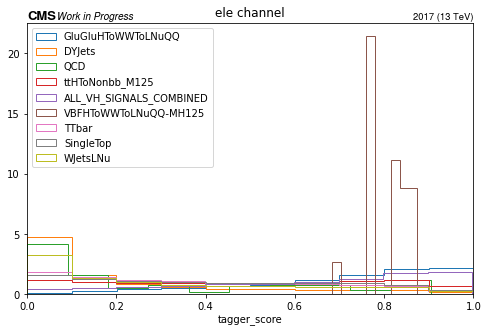

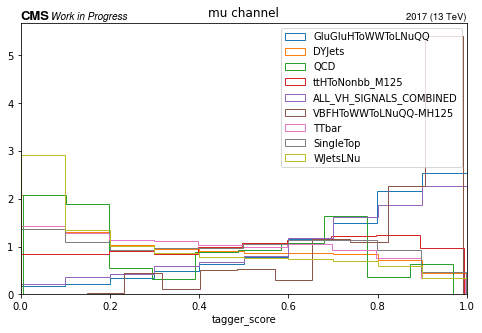

In [65]:
year = '2017'
channels = ['ele', 'mu']
for ch in channels:
    
    fig, ax = plt.subplots(figsize=(8, 5))

    # make plots per channel
    for sample in data[ch]['sample'].unique():
        plt.hist(data[ch]['tagger_score'][data[ch]['sample']==sample], 
#                      bins=50, 
                 label=sample, 
                 density=True,
                 histtype='step',)
#                  weights=data[ch]['weight'][data[ch]['sample']==sample])

    ax.legend()
    ax.set_xlabel(f"tagger_score")
    ax.set_title(f'{ch} channel')
    ax.set_xlim(0,1)
    hep.cms.lumitext(f"{year} (13 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax);
#     plt.savefig(f'/Users/fmokhtar/Desktop/plots/{ch}_gen_HpTplots.pdf')
    # plt.close()
#     break

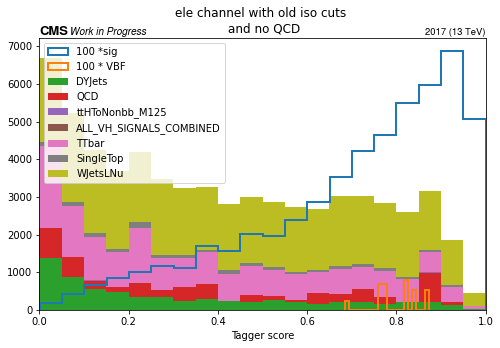

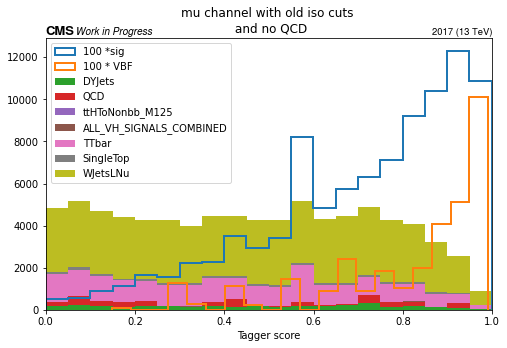

In [111]:
year = '2017'
channels = ['ele', 'mu']
for ch in channels:
    
    fig, ax = plt.subplots(figsize=(8, 5))

    # GluGluHToWWToLNuQQ
    plt.hist(data[ch]['tagger_score'][data[ch]['sample']=='GluGluHToWWToLNuQQ'], 
             bins=20,
             label='100 *sig', 
#              density=True,
             histtype='step',
             linewidth=2,
                weights=100*data[ch]['weight'][data[ch]['sample']=='GluGluHToWWToLNuQQ']
            )
    
    # VBF 
    plt.hist(data[ch]['tagger_score'][data[ch]['sample']=='VBFHToWWToLNuQQ-MH125'], 
            bins=20, 
             label='100 * VBF', 
#              density=True,
             histtype='step',
             linewidth=2,             
                weights=100*data[ch]['weight'][data[ch]['sample']=='VBFHToWWToLNuQQ-MH125']

            )
    
    # background
    xs = []
    labels = []
    weightss = []
    for sample in samples:
        if sample !='GluGluHToWWToLNuQQ' and sample !='VBFHToWWToLNuQQ-MH125':
            xs.append(data[ch]['tagger_score'][data[ch]['sample']==sample])
            labels.append(sample)
            weightss.append(data[ch]['weight'][data[ch]['sample']==sample])

    plt.hist(xs, 
             label=labels, 
             bins=20,             
#              density=True,
#              histtype='step',
             stacked=True,
            weights=weightss)

    ax.legend(loc='upper left')
    ax.set_xlabel(f"Tagger score")
    ax.set_title(f'{ch} channel with old iso cuts \n and no QCD')
    ax.set_xlim(0,1)
    hep.cms.lumitext(f"{year} (13 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax);
    plt.savefig(f'/Users/fmokhtar/Desktop/plots/{ch}_tagger_score_old_cuts.pdf')
    # plt.close()
#     break